<a href="https://colab.research.google.com/github/phongidoit/Computer_vision/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/data ML/Facial.zip"

Archive:  /content/drive/MyDrive/data ML/Facial.zip
   creating: Facial/
   creating: Facial/Luong/
  inflating: Facial/Luong/Luong_000.png  
  inflating: Facial/Luong/Luong_001.png  
  inflating: Facial/Luong/Luong_002.png  
  inflating: Facial/Luong/Luong_003.png  
  inflating: Facial/Luong/Luong_004.png  
  inflating: Facial/Luong/Luong_005.png  
  inflating: Facial/Luong/Luong_006.png  
  inflating: Facial/Luong/Luong_007.png  
  inflating: Facial/Luong/Luong_008.png  
  inflating: Facial/Luong/Luong_009.png  
  inflating: Facial/Luong/Luong_010.png  
  inflating: Facial/Luong/Luong_011.png  
  inflating: Facial/Luong/Luong_012.png  
  inflating: Facial/Luong/Luong_013.png  
  inflating: Facial/Luong/Luong_014.png  
  inflating: Facial/Luong/Luong_015.png  
  inflating: Facial/Luong/Luong_016.png  
  inflating: Facial/Luong/Luong_017.png  
  inflating: Facial/Luong/Luong_018.png  
  inflating: Facial/Luong/Luong_019.png  
  inflating: Facial/Luong/Luong_020.png  
  inflating: Facia

**Repo sử dụng MTCNN đã được pre-trained:** https://github.com/timesler/facenet-pytorch


In [3]:
#the notebook start here
!pip install facenet-pytorch

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.5 MB/s eta 0:00:00


In [11]:
data_dir = "/content/Facial"

batch_size=32
epochs= 5
workers = 0 if os.name == 'nt' else 8


In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)


Running on device: cuda:0


In [6]:

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
#del mtcnn

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 17 of 17

In [7]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)
print(dataset.class_to_idx)

  0%|          | 0.00/107M [00:00<?, ?B/s]

{'Luong': 0, 'Phong': 1}


In [8]:
#Run here if you want to download the cropped version of face
from google.colab import files
!zip -r /content/Facial_cropped.zip /content/Facial_cropped
#files.download("/content/Facial_cropped.zip")

  adding: content/Facial_cropped/ (stored 0%)
  adding: content/Facial_cropped/Phong/ (stored 0%)
  adding: content/Facial_cropped/Phong/video_051.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_023.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_118.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_070.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_192.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_185.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_108.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_165.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_079.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_146.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_196.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_198.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_061.png (stored 0%)
  adding: content/Facial_cropped/Phong/video_089.png (sto

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [12]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('Initial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

Initial
----------
Valid |     4/4    | loss:    0.9760 | fps:  291.7401 | acc:    0.2005   

Epoch 1/9
----------
Train |    14/14   | loss:    0.0749 | fps:  207.9755 | acc:    0.9531   
Valid |     4/4    | loss:    0.0372 | fps:  473.3887 | acc:    1.0000   

Epoch 2/9
----------
Train |    14/14   | loss:    0.0000 | fps:  220.7261 | acc:    1.0000   
Valid |     4/4    | loss:    0.0000 | fps:  553.9029 | acc:    1.0000   

Epoch 3/9
----------
Train |    14/14   | loss:    0.0000 | fps:  215.4497 | acc:    1.0000   
Valid |     4/4    | loss:    0.0000 | fps:  522.7305 | acc:    1.0000   

Epoch 4/9
----------
Train |    14/14   | loss:    0.0000 | fps:  219.2518 | acc:    1.0000   
Valid |     4/4    | loss:    0.0000 | fps:  485.5131 | acc:    1.0000   

Epoch 5/9
----------
Train |    14/14   | loss:    0.0000 | fps:  198.1085 | acc:    1.0000   
Valid |     4/4    | loss:    0.0000 | fps:  567.6254 | acc:    1.0000   

Epoch 6/9
----------
Train |    14/14   | loss:    0.000

In [61]:
#Take a real picture and compare
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
  

<IPython.core.display.Javascript object>

Saved to photo.jpg


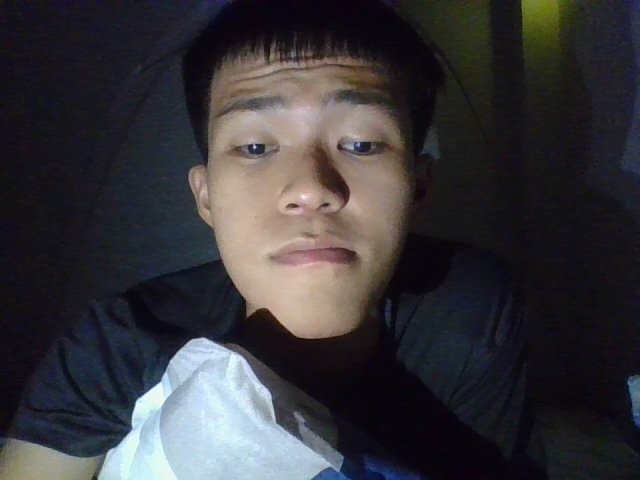

In [101]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [95]:
print(filename)

photo.jpg


In [102]:
from facenet_pytorch import MTCNN
from PIL import Image


filename_crop = mtcnn(Image.open("/content/photo.jpg"))
filename_crop_gpu = filename_crop.cuda()

result = resnet(filename_crop_gpu.reshape(1, 3, 160, 160))

Luong 4.5118127
[[ 4.5118127 -5.0774817]]


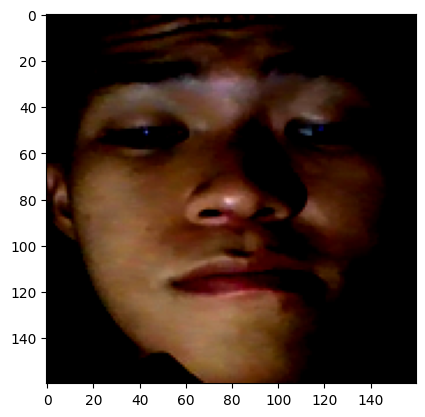

In [105]:
res_info = result.cpu().detach().numpy()

x=np.argmax(res_info)
#dic=dataset.class_to_idx
for name, val in dataset.class_to_idx.items():
  if val==x:
    print(name, res_info[0][val])
    break

plt.imshow(filename_crop.permute(1,2,0))
print(res_info)

(3, 160, 160)